# Deep Learning: More Recurrent Neural Networks

In [2]:
import torch
import torch.nn as nn
import torchtext
from torchtext.data import Field, LabelField, BucketIterator
from torchtext.datasets import SST
from tqdm import tqdm
import matplotlib.pyplot as plt
torch.manual_seed(12)

print(f"Pytorch version: {torch.__version__}")
print(f"Torchtext version: {torchtext.__version__}")

Pytorch version: 2.3.1.post100
Torchtext version: 0.6.0



### Note: Python must be 3.11.x

If your kernel shows a value > 3.11.x you will need to downgrade. Please email the staff for help

In [3]:
# DEVICE CONFIGURATION
if torch.backends.mps.is_available():          # Apple Silicon
    device = torch.device("mps")
elif torch.cuda.is_available():                # CUDA GPU
    device = torch.device("cuda")
else:
    device = torch.device("cpu")               # Fallback

print("Using device:", device)

Using device: mps


In [4]:
# Define field types
TEXT = Field(tokenize='basic_english', lower=True, include_lengths=True)
LABEL = LabelField(dtype=torch.float)

# Load SST data
train_data, _, test_data = SST.splits(
    TEXT, LABEL, fine_grained=False
)

In [14]:
# Display size of datasets
print("Train size:", len(train_data))
print("Test size:", len(test_data))

Train size: 8544
Test size: 2210


The `.splits` method is splitting up our dataset so that our train and test sets both have representative samples. 

The `fine_grained` parameter determines how many categories our data is broken into.
- if `True`: labels can be {'positive': 0, 'negative': 1, 'neutral': 2, 'very positive': 3, 'very negative': 4}
- if `False`: labels can be {'positive': 0, 'negative': 1, 'neutral': 2}

In [6]:
# Build vocabulary
MAX_VOCAB_SIZE = 10000
TEXT.build_vocab(train_data, max_size=MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

vocab = TEXT.vocab.stoi
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

### Q: What variable type is `vocab`? What does the `.build_vocab` method do?
Hint: `.stoi` stand for "string to int"!

### A: 
YOUR ANSWER HERE

In [7]:
def decode_dataset(dataset):
    # Reverse label mapping: string -> int
    label_stoi = LABEL.vocab.stoi
    texts = [example.text for example in dataset] 
    labels = [label_stoi[example.label] for example in dataset]
    return texts, labels

train_texts, train_labels = decode_dataset(train_data)
test_texts, test_labels   = decode_dataset(test_data)

### Sanity Check 🧠 
Let's check that the decoded dataset makes sense!

In [8]:
label_map = {idx: word for word, idx in LABEL.vocab.stoi.items()}

# Change i and see what happens!
i = 0

print(" ".join(test_texts[i]))
print(label_map[test_labels[i]])

effective but too-tepid biopic
neutral


----

Now let's define a `BucketIterator`:

In [9]:
BATCH_SIZE = 32
train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data),
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    sort_key=lambda x: len(x.text),
    device=device
)

Below is a custom classifier:

In [ ]:
# Custom LSTM Classifier
class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=False)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lengths):
        # text: [batch_size, seq_len] if batch_first=True
        embedded = self.embedding(text)  # [batch_size, seq_len, emb_dim]

        # Pack padded sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=False, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        # hidden: [1, batch_size, hidden_dim]  -> take the last hidden state
        return self.fc(hidden.squeeze(0))  # [batch_size, output_dim]

Here's a helper function so we can vary parameters later:

In [28]:
# TRAINING LOOP FUNCTION
def run_training_loop(num_epochs, random_state):
    # set random seed
    torch.manual_seed(random_state)

    EMBEDDING_DIM = 100
    HIDDEN_DIM = 256
    OUTPUT_DIM = 1

    # Send model to device
    model = SimpleLSTM(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, pad_idx).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # init output vars
    train_losses = []
    train_accs = []

    # train for num_epochs
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0

        # Wrap the iterator with tqdm
        for batch in tqdm(train_iterator, desc=f"Epoch {epoch+1}/{num_epochs}"):
            text, text_lengths = batch.text
            labels = batch.label

            text, text_lengths, labels = text.to(device), text_lengths.to(device), labels.to(device)

            optimizer.zero_grad()
            predictions = model(text, text_lengths).squeeze(1)

            # Loss
            loss = criterion(predictions, labels.float())
            loss.backward()
            optimizer.step()

            # Optional: compute accuracy
            preds = torch.round(torch.sigmoid(predictions))
            acc = (preds == labels).float().mean()
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
        avg_loss = epoch_loss/ len(train_iterator)
        avg_acc = epoch_acc/ len(train_iterator)
        train_losses.append(avg_loss)
        train_accs.append(avg_acc)
        print(f"Loss = {avg_loss:.4f}, Accuracy = {avg_acc:.4f}\n")
    return train_losses, train_accs, model

And another helper function plot the `train_losses` and `train_accs`:

In [29]:
def plot_training_performance(train_losses, train_accs, num_epochs, random_state):
    fig = plt.figure(figsize=(8,4), tight_layout=True)
    fig.suptitle(f"Model Training for State {random_state} over {num_epochs} Epochs")

    plt.subplot(1,2,1)
    plt.plot(train_losses, "-o", label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_accs, "-o", label="Train Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid()
    plt.legend()
    plt.show()


Let's train our model!

In [40]:
NUM_EPOCHS = 15
RANDOM_STATE = 42
train_losses, train_accs, model = run_training_loop(NUM_EPOCHS, RANDOM_STATE)

Epoch 1/15: 100%|██████████| 267/267 [00:06<00:00, 44.16it/s]


Loss = 0.5197, Accuracy = 0.4009



Epoch 2/15: 100%|██████████| 267/267 [00:05<00:00, 45.64it/s]


Loss = 0.3673, Accuracy = 0.4808



Epoch 3/15: 100%|██████████| 267/267 [00:05<00:00, 45.44it/s]


Loss = -0.1195, Accuracy = 0.5270



Epoch 4/15: 100%|██████████| 267/267 [00:05<00:00, 45.57it/s]


Loss = -2.5380, Accuracy = 0.5756



Epoch 5/15: 100%|██████████| 267/267 [00:05<00:00, 45.74it/s]


Loss = -8.4015, Accuracy = 0.6096



Epoch 6/15: 100%|██████████| 267/267 [00:05<00:00, 44.98it/s]


Loss = -18.0771, Accuracy = 0.6276



Epoch 7/15: 100%|██████████| 267/267 [00:05<00:00, 45.14it/s]


Loss = -31.0187, Accuracy = 0.6678



Epoch 8/15: 100%|██████████| 267/267 [00:05<00:00, 45.29it/s]


Loss = -42.1147, Accuracy = 0.6651



Epoch 9/15: 100%|██████████| 267/267 [00:05<00:00, 45.36it/s]


Loss = -56.3484, Accuracy = 0.6949



Epoch 10/15: 100%|██████████| 267/267 [00:05<00:00, 45.43it/s]


Loss = -70.0181, Accuracy = 0.6999



Epoch 11/15: 100%|██████████| 267/267 [00:05<00:00, 45.42it/s]


Loss = -80.7207, Accuracy = 0.7067



Epoch 12/15: 100%|██████████| 267/267 [00:06<00:00, 44.27it/s]


Loss = -94.8596, Accuracy = 0.7188



Epoch 13/15: 100%|██████████| 267/267 [00:05<00:00, 45.18it/s]


Loss = -106.5866, Accuracy = 0.7137



Epoch 14/15: 100%|██████████| 267/267 [00:05<00:00, 44.97it/s]


Loss = -116.5772, Accuracy = 0.7148



Epoch 15/15: 100%|██████████| 267/267 [00:06<00:00, 40.34it/s]

Loss = -128.5909, Accuracy = 0.7197



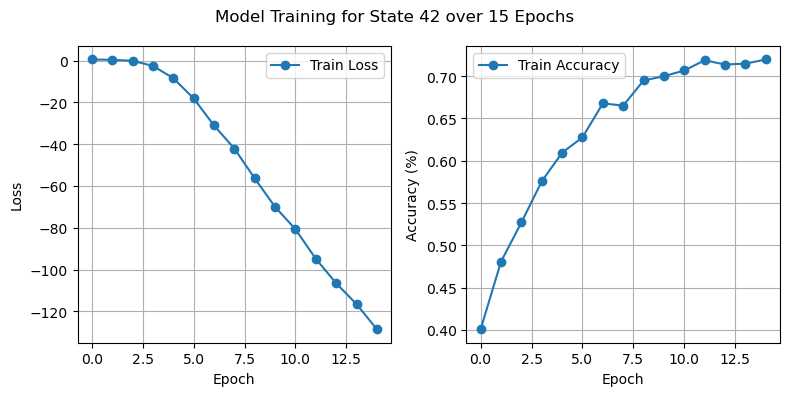

In [41]:
plot_training_performance(train_losses, train_accs, NUM_EPOCHS, RANDOM_STATE)

### Q: Try changing the value of `NUM_EPOCHS`. What happens to the train loss and accuracy plots? What does this tell us about the optimal number of training epochs?

### A: 
YOUR ANSWER HERE

### Q: Try changing the value of `RANDOM_STATE`. What happens to the train loss and accuracy plots? What does this tell us about the impact of the initial guess (i.e. epoch 0)?

### A: 
YOUR ANSWER HERE

----

## Performance on the Test Set

Here's a helper function to run our model on the test data:

In [ ]:

# Evaluate on test set
def run_evaluation_test():
    model.eval()
    test_loss, test_acc, = 0,0

    with torch.no_grad():
        for batch in test_iterator:
            text, text_lengths = batch.text
            labels = batch.label

            text = text.to(device)
            text_lengths = text_lengths.to(device)
            labels = labels.to(device)

            criterion = nn.BCEWithLogitsLoss()
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, labels.float())

            preds = torch.round(torch.sigmoid(predictions))
            acc = (preds == labels).float().mean()

            test_loss += loss.item()
            test_acc += acc.item()

    return print(f"Test Accuracy: {100 * test_acc / len(test_iterator):.2f}%")


Finally, let's check that our model can generalize by processing the test data:

In [42]:
run_evaluation_test()

Test Accuracy: 56.34%


----
## Further Exploration 🔎

### Q: What happens to the **test** accuracy as `NUM_EPOCHS` is changed? What does this tell us about our neural network?
Note: remember to re-train your model before running on the test set!

### A:
YOUR ANSWER HERE

### Q: What happens to the **test** accuracy as `RANDOM_STATE` is changed? What does this tell us about our neural network?
Note: remember to re-train your model before running on the test set!

### A:
YOUR ANSWER HERE

### Q: What happens to your results if you set `find_grained=True`?
Try to predict first and then test your hypothesis by changing the value and re-running the notebook!

### A: 
YOUR ANSWER HERE